# Big Data Mart Sales Problem

Problem Statement:

The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and find out the sales of each product at a particular store.

Using this model, BigMart will try to understand the properties of products and stores which play a key role in increasing the sales of their products.

The dataset includes two files:

- bigdatamart_Train.csv: Use this file for the model building purpose. 

- bigdatamart_Test.csv: Use this file for getting predictions from the trained model. 

In [1]:
###the objective of the project is to build a model to predict sales of each product at particular stores.
###Hence its a continuous regression problem with Sales as the target variable.

# Loading libraries and Dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt              #for plotting and EDA
import seaborn as sns                        #for plotting and Eda
from sklearn.model_selection import train_test_split         #for splitting dataset into train and test
from sklearn.metrics import r2_score                         #for model evaluation
from sklearn.metrics import mean_squared_error               #for model evaluation
from sklearn.linear_model import LinearRegression            #regression model
from sklearn.tree import DecisionTreeRegressor               #regression model
from sklearn.ensemble import RandomForestRegressor           #regression model
from sklearn.metrics import mean_absolute_error                          #for checking model accuracy
from sklearn.model_selection import cross_val_score                      #for cross validating model
import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('bigdatamart_Train.csv')
test = pd.read_csv('bigdatamart_Test.csv')

In [4]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


There seems to be some missing values in the dataset.

In [5]:
test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In Item_Fat_Content different variables are sometimes used for same type of values like reg and Regular are same but represented differently.

In [6]:
train.shape, test.shape

((8523, 12), (5681, 11))

# Merging the train and test dataset for data cleaning

Since we have separate train and test datasets, we will approach it by first merging the two datasets into one for exploring and cleaning the data, after all that process we will separate the datasets back to train and test as they were provided.

In [7]:
train['source']='train'
test['source']='test'
data = pd.concat([train, test],ignore_index=True)
train.shape, test.shape, data.shape

((8523, 13), (5681, 12), (14204, 13))

We introduce another column in the two datasets namely 'source', so it will be easy for us to separate the two datasets after data cleaning.

In [8]:
data.dtypes                                    #for checking the data types of all the columns present

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
source                        object
dtype: object

Item_Identifier and Outlet_Identifier are unique values associated with every item and outlet respectively.

Item_Weight, Item_Visibility, Item_MRP, Outlet_Establishment_Year are continuous datas.

Item_Fat_Content, Item_Type, Outlet_Size, Outlet_Location_Type, Outlet_Type are categorical datas.

Item_Outlet_Sales is our target variable and it is continuous in nature.

In [9]:
data.apply(lambda x: len(x.unique()))

Item_Identifier               1559
Item_Weight                    416
Item_Fat_Content                 5
Item_Visibility              13006
Item_Type                       16
Item_MRP                      8052
Outlet_Identifier               10
Outlet_Establishment_Year        9
Outlet_Size                      4
Outlet_Location_Type             3
Outlet_Type                      4
Item_Outlet_Sales             3494
source                           2
dtype: int64

In [10]:
data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,11765.000000,14204.000000,14204.000000,14204.000000,8523.000000
mean,12.792854,0.065953,141.004977,1997.830681,2181.288914
std,4.652502,0.051459,62.086938,8.371664,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.710000,0.027036,94.012000,1987.000000,834.247400
50%,12.600000,0.054021,142.247000,1999.000000,1794.331000
75%,16.750000,0.094037,185.855600,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


The first thing we notice is that count for item weight is less than the count for other columns except item outlet sales, hence there are missing values in item weight.

Mean for item weight is 12.79 which is around the mode of data 12.60. The range is 4.55 - 21.35.

Mean for item visibility is 0.07 and mode is 0.05. The range is 0 - 0.33, the 0 value seems to represent missing values because it is not possible to have item visibility 0 since they are up for sale.

Mean for item MRP is 141.00 which is around the mode of data 142.25. The range is 31.29 - 266.89.

Mean for outlet establishment year is 1997 and the mode of data is 1999. The range is 1985 - 2009

# Checking and treating missing values

In [11]:
data.isnull().sum()

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
source                          0
dtype: int64

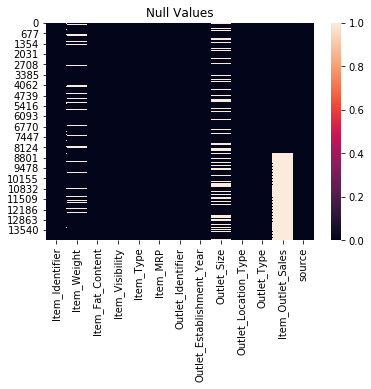

In [12]:
sns.heatmap(data.isnull())                                      #null values present in dataset
plt.title('Null Values')
plt.show()

In [13]:
s = (data.dtypes == 'object')
cate_cols = list(s[s].index)

print("Categorical variables:")
print(cate_cols)

Categorical variables:
['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'source']


In [14]:
cate_cols.remove('Item_Identifier')
cate_cols.remove('Outlet_Identifier')
cate_cols

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type',
 'source']

In [15]:
item_weight_mean = data.pivot_table(values='Item_Weight', index='Item_Identifier')
item_weight_mean

,Item_Weight
Item_Identifier,
DRA12,11.600
DRA24,19.350
DRA59,8.270
DRB01,7.390
DRB13,6.115
...,...
NCZ30,6.590
NCZ41,19.850
NCZ42,10.500


In [16]:
#Get a boolean variable specifying missing Item_Weight values
miss_bool = data['Item_Weight'].isnull() 
miss_bool


0        False
1        False
2        False
3        False
4        False
         ...  
14199    False
14200    False
14201    False
14202    False
14203    False
Name: Item_Weight, Length: 14204, dtype: bool

In [17]:
for i, item in enumerate(data['Item_Identifier']):
    if miss_bool[i]:
        if item in item_weight_mean:
            data['Item_Weight'][i] = item_weight_mean.loc[item]['Item_Weight']
        else:
            data['Item_Weight'][i] = np.mean(data['Item_Weight'])


We replaced the null values in Item weight by comparing the values in Item Identifier, if the value is new then and no other product has the same item identifier then we have replaced the missing weight value with mean of all the weights.

In [18]:
data['Item_Weight'].isnull().sum()

0

In [19]:
outlet_size_mode = data.pivot_table(values = 'Outlet_Size', columns = 'Outlet_Type', aggfunc = lambda x: x.mode()[0])
outlet_size_mode

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


In [20]:
miss_bool = data['Outlet_Size'].isnull() 
data.loc[miss_bool, 'Outlet_Size'] = data.loc[miss_bool, 'Outlet_Type'].apply(lambda x: outlet_size_mode[x])

We replaced the missing values in outlet size by comparing the values in outlet type and then inputing the mode of the desired outlet type in outlet size.

In [21]:
data['Outlet_Size'].isnull().sum()

0

In [22]:
sum(data['Item_Visibility'] == 0)

879

In [23]:
data.loc[:, 'Item_Visibility'].replace([0], [data['Item_Visibility'].mean()], inplace = True)

We replaced the 0 value in invisibility with mean of values present in Item visibility.

In [24]:
sum(data['Item_Visibility'] == 0)

0

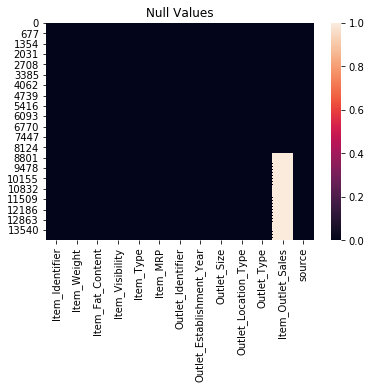

In [25]:
sns.heatmap(data.isnull())                                      #no null values present in dataset
plt.title('Null Values')
plt.show()

# Feature Engineering

In [26]:
for col in cate_cols:
    print(col)
    print(data[col].value_counts())
    print()

Item_Fat_Content
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Item_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64

Outlet_Size
Small     7996
Medium    4655
High      1553
Name: Outlet_Size, dtype: int64

Outlet_Location_Type
Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64

Outlet_Type
Supermarket Type1    9294
Grocery Store        1805
Supermarket Type3    1559
Supermarket Type2    1546
Name: Outlet_Type, dtype: int6

There should be only 2 categories in item fat content Low Fat and Regular, but there are 5 values due to repetition and typing errors.

There are 16 categories in item type column, maybe we can merge few categories to reduce this value.

In [27]:
data['Item_Fat_Content'].replace('LF', 'Low Fat', inplace = True)
data['Item_Fat_Content'].replace('low fat', 'Low Fat', inplace = True)
data['Item_Fat_Content'].replace('reg', 'Regular', inplace = True)

In [28]:
data['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular'], dtype=object)

In [29]:
data['New_Item_Types'] = data['Item_Identifier'].apply(lambda x: x[:2])
data['New_Item_Types']

0        FD
1        DR
2        FD
3        FD
4        NC
         ..
14199    FD
14200    FD
14201    NC
14202    FD
14203    FD
Name: New_Item_Types, Length: 14204, dtype: object

In [30]:
data['New_Item_Types'] = data['New_Item_Types'].map({'FD': 'Food', 'NC': 'Non-Consumable', 'DR': 'Drinks'})

We created a new column merging few items from Item types with the help of item identifier. The first 2 letters in item identifier identifies whether the item is FD or food, DR or Drink, NC or Non Consumable.

In [31]:
data['New_Item_Types'].value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: New_Item_Types, dtype: int64

In [32]:
data.loc[data['New_Item_Types'] == 'Non-Consumable', 'Item_Fat_Content'] = 'Non-Edible'
data['Item_Fat_Content'].value_counts()

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64

Since there are non consumable items present in dataset hence fat content doesnt necessarily matters in non consumable items. So we have added another variable non edible for those items which doesnt require the fat content.

In [33]:
data['Outlet_Years'] = 2013 - data['Outlet_Establishment_Year']

In [34]:
data['Outlet_Years']

0        14
1         4
2        14
3        15
4        26
         ..
14199    16
14200     4
14201    11
14202     6
14203    11
Name: Outlet_Years, Length: 14204, dtype: int64

Outlet Establishment year is a high value, we created a new column from it which tells us the age of the establishment at the time of data collection since it is the only use of outlet establishment year.

In [35]:
cate_cols.remove('Item_Type')
cate_cols.append('New_Item_Types')
cate_cols.remove('source')
cate_cols

['Item_Fat_Content',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type',
 'New_Item_Types']

In [36]:
cont_cols = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Years']

# EDA and Data Visualisation

In [37]:
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source,New_Item_Types,Outlet_Years
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train,Food,14
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train,Drinks,4
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train,Food,14
3,FDX07,19.20,Regular,0.065953,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,train,Food,15
4,NCD19,8.93,Non-Edible,0.065953,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train,Non-Consumable,26


In [38]:
cols = ['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_MRP', 'Outlet_Size', 'Outlet_Location_Type', 
        'Outlet_Type', 'Item_Outlet_Sales', 'New_Item_Types', 'Outlet_Years']

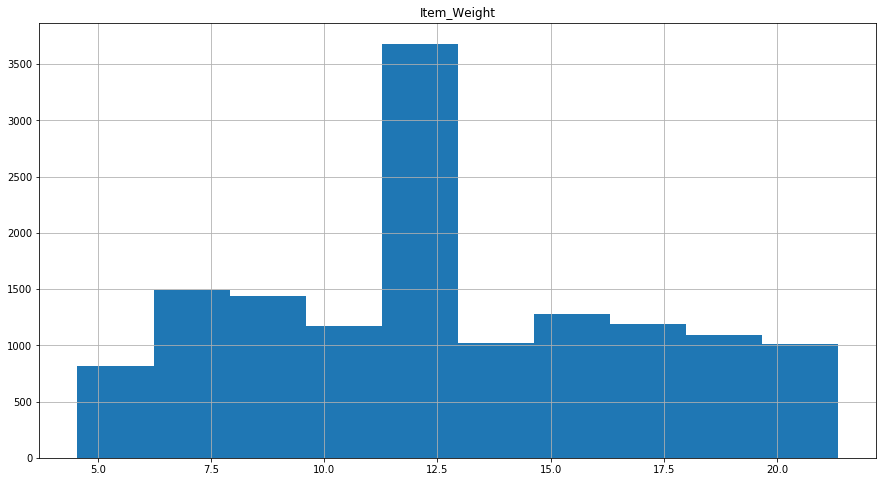

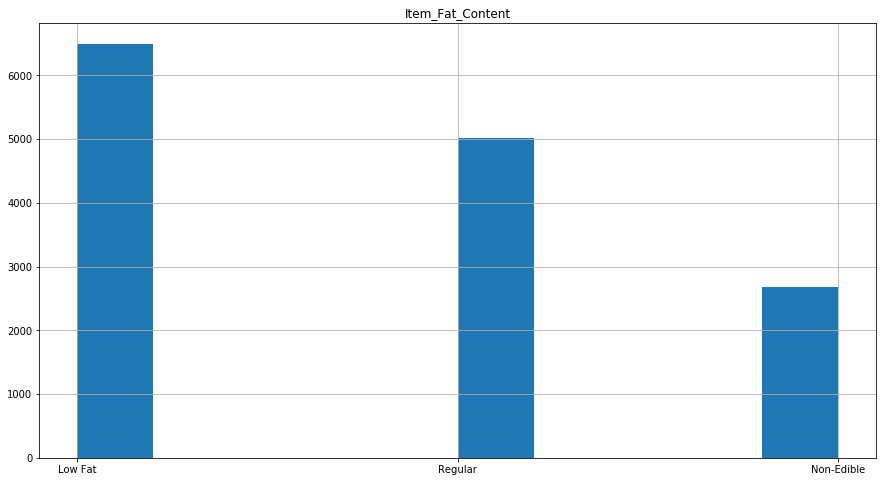

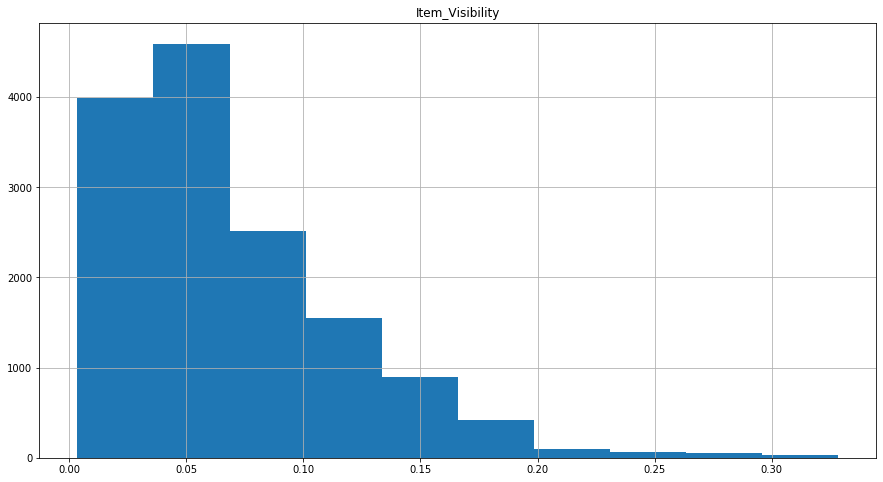

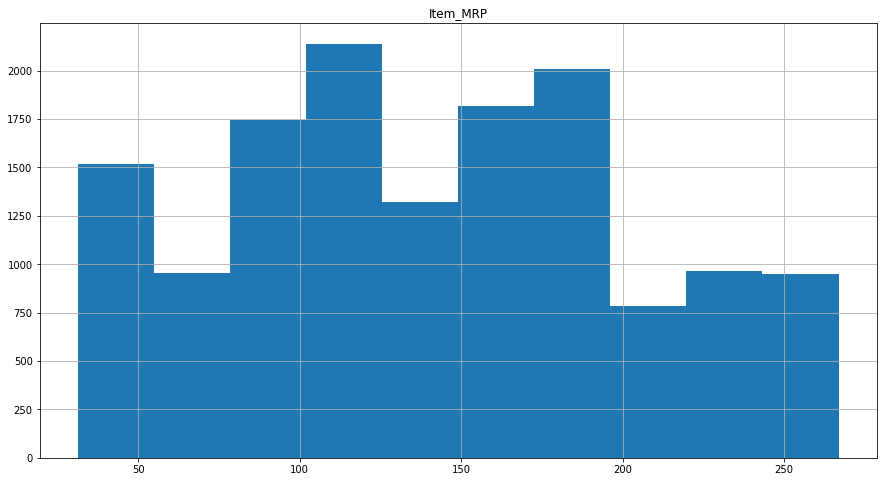

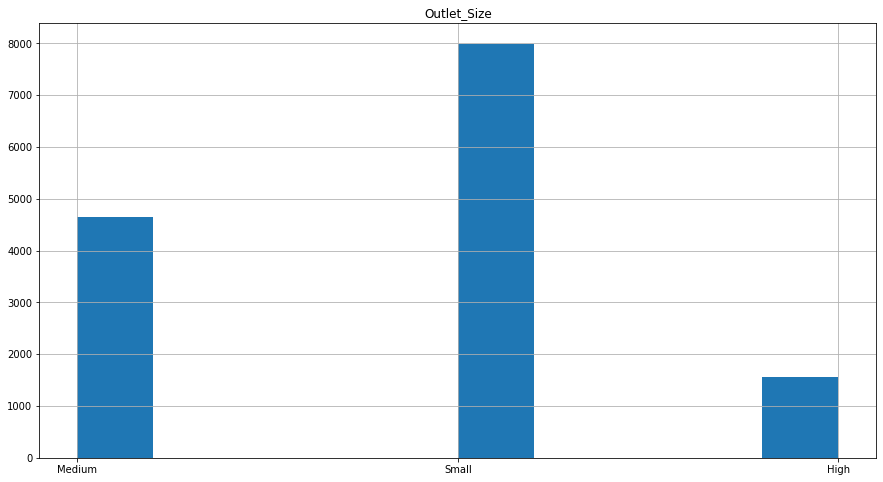

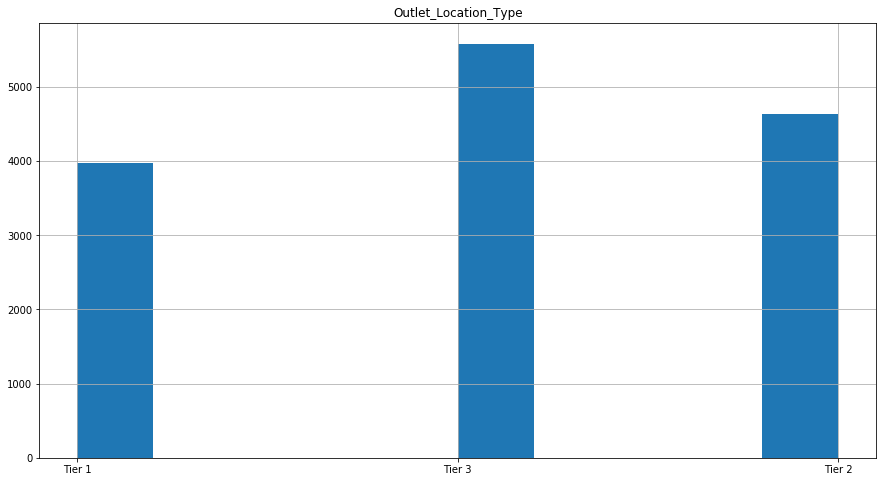

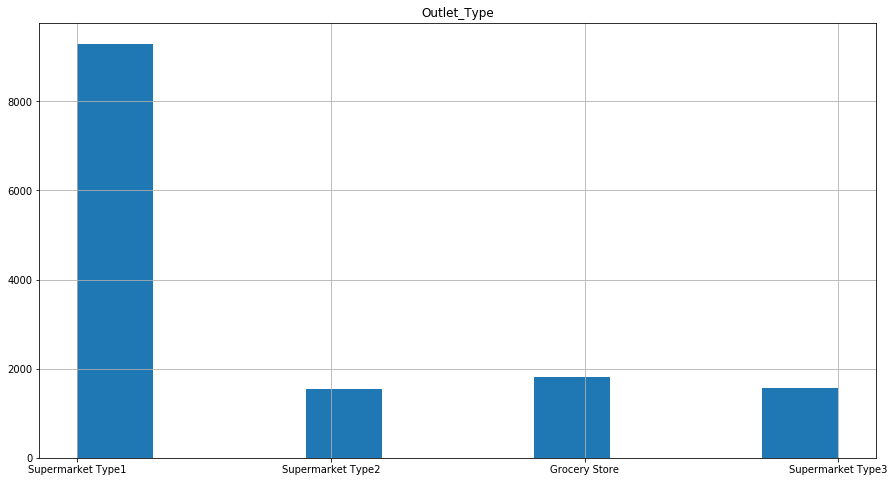

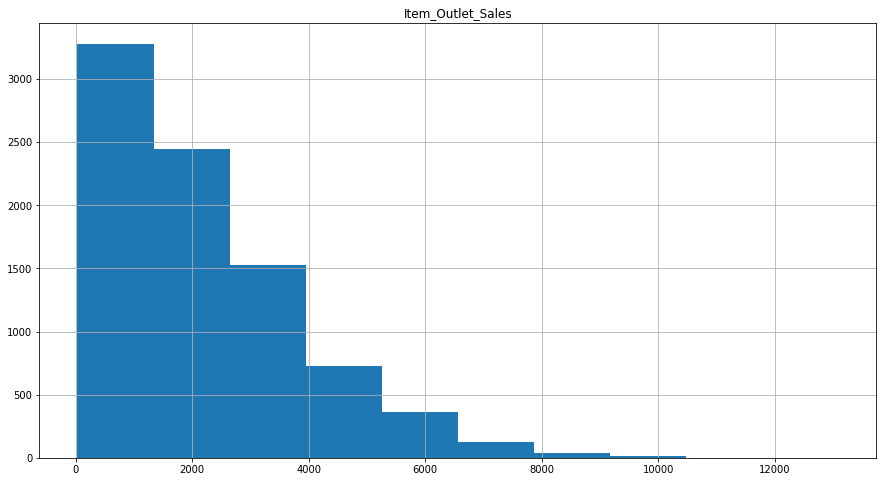

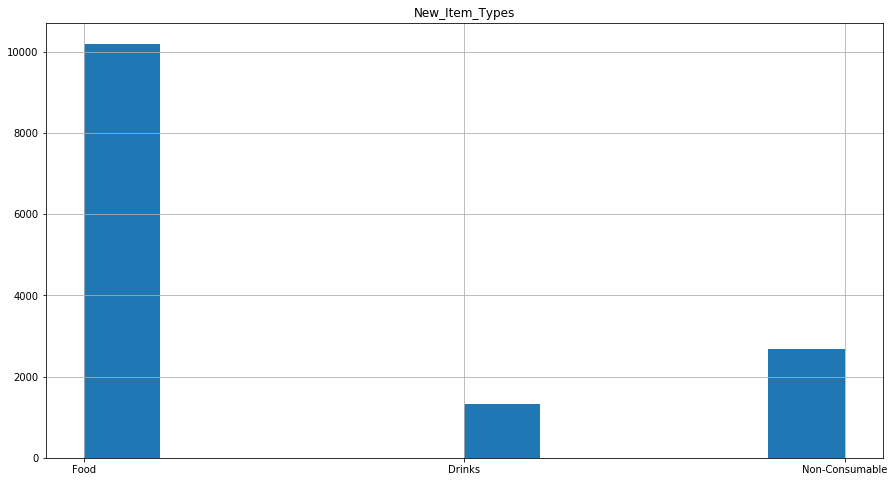

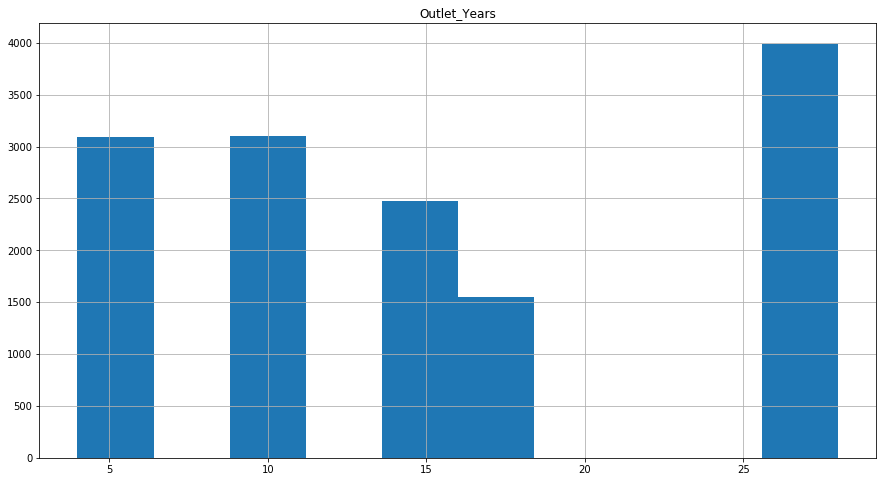

In [39]:
for i in cols:
    plt.figure(figsize = (15, 8))
    data[i].hist(grid = True)
    plt.title(i)
    plt.show()

Observations from Graphs:

Items weighing around 12.5 has the highest frequency.

Low fat items has the highest frequency followed by regular and then non edibles.

Item visibility has a steep decline.

Small outlet size are highest followed by medium and then high, there are very few high outlet size compared to other two.

Tier 3 locations have highest frequency followed by tier 2 and then tier 1.

Supermarket Type 1 are more than Supermarket Type 2, Grocery Store, Supermarket Type 3 combined

Steep decline in item outlet sales graph.

Food ranks highest followed by non consumables and then finally drinks in item types.

Most of the outlets are 25+ years old but a lot of new outlets has been established in the past 5-10 years.

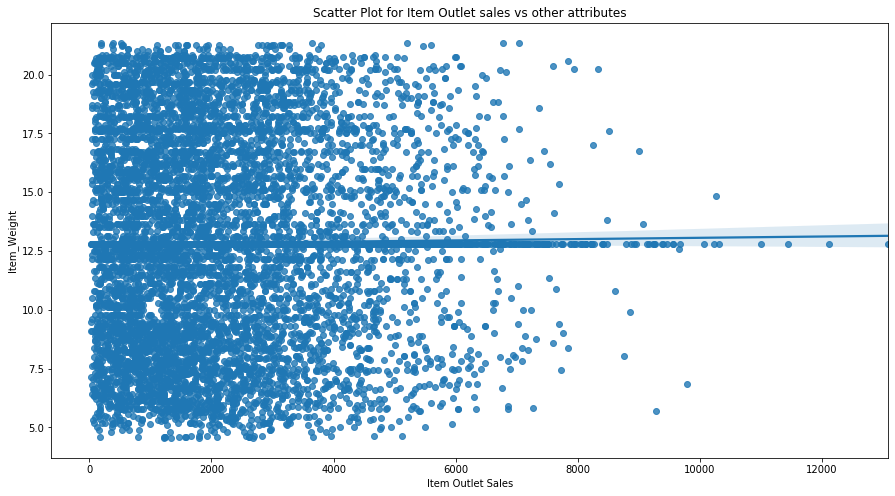

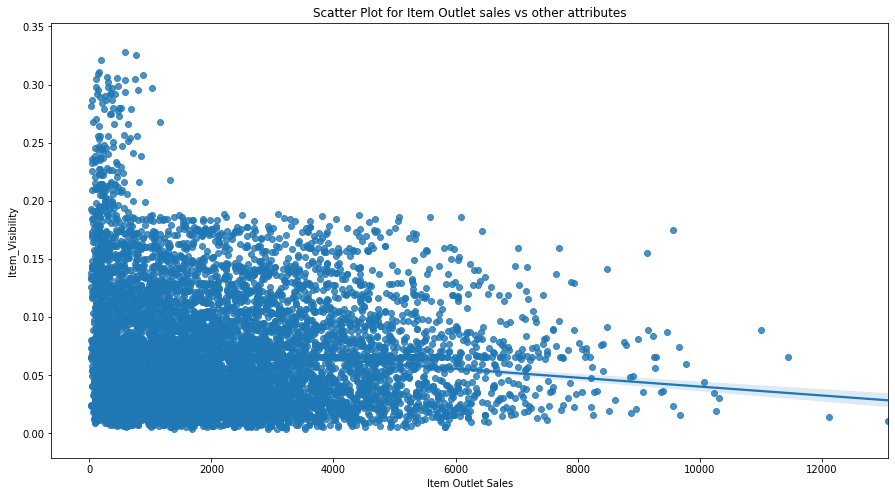

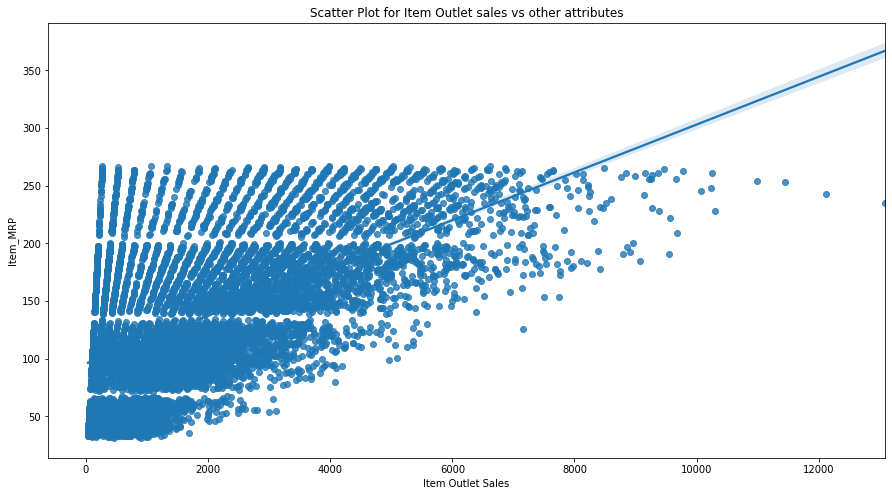

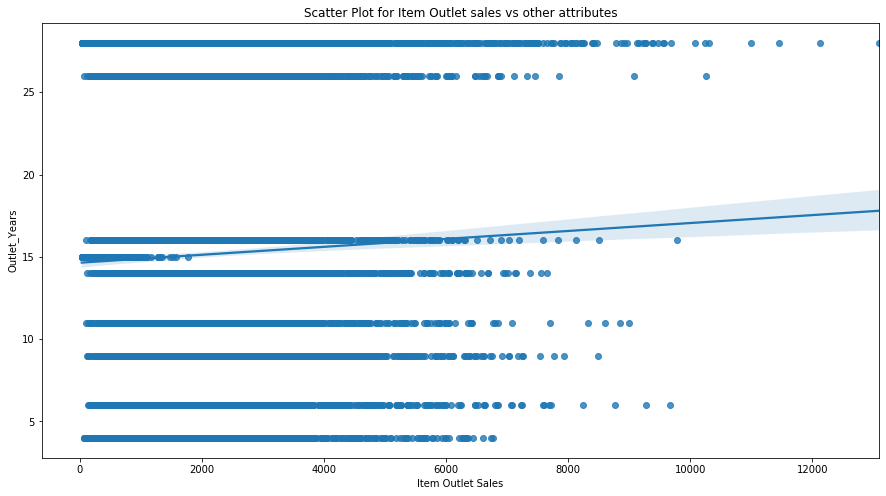

In [40]:
for i in cont_cols:                                      #bivariate analysis
    plt.figure(figsize = (15, 8))
    sns.regplot(data['Item_Outlet_Sales'], data[i])
    plt.title('Scatter Plot for Item Outlet sales vs other attributes')
    plt.xlabel('Item Outlet Sales')
    plt.ylabel(i)  
    plt.show()

Item MRP has some sort of linear relationship with item outlet sales apart from that there isnt much relationship between other components and item outlet sales.

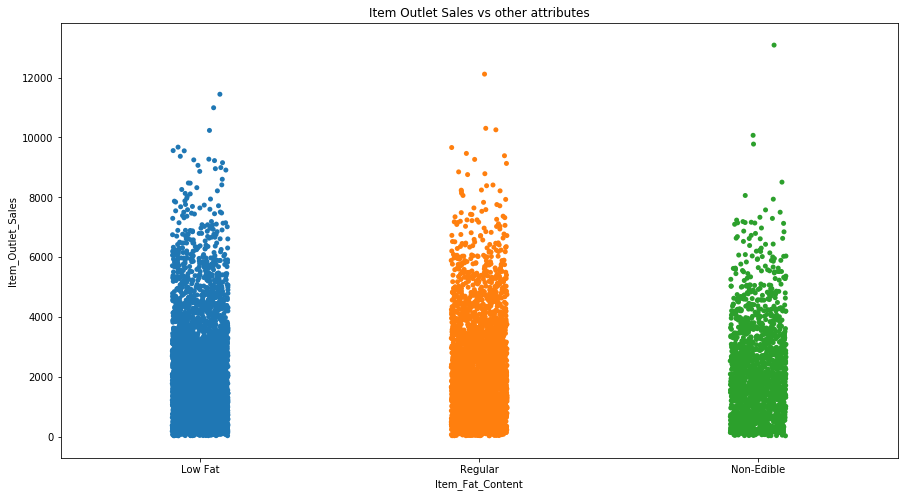

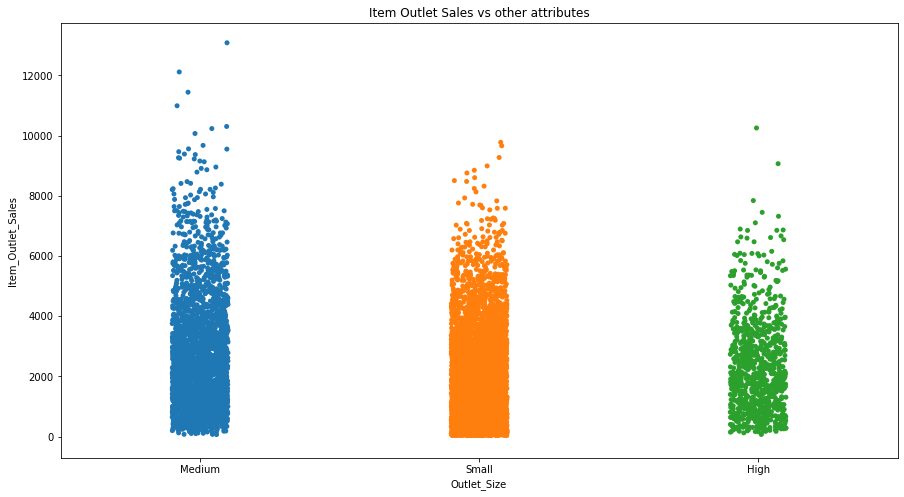

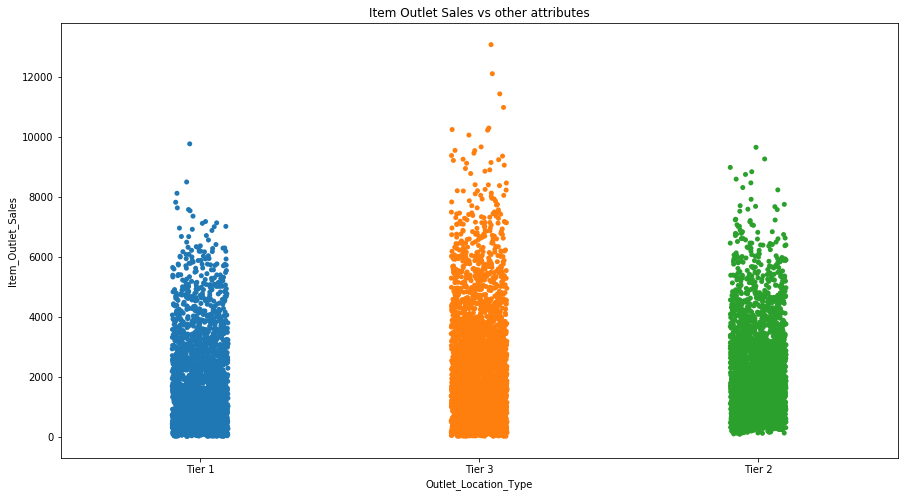

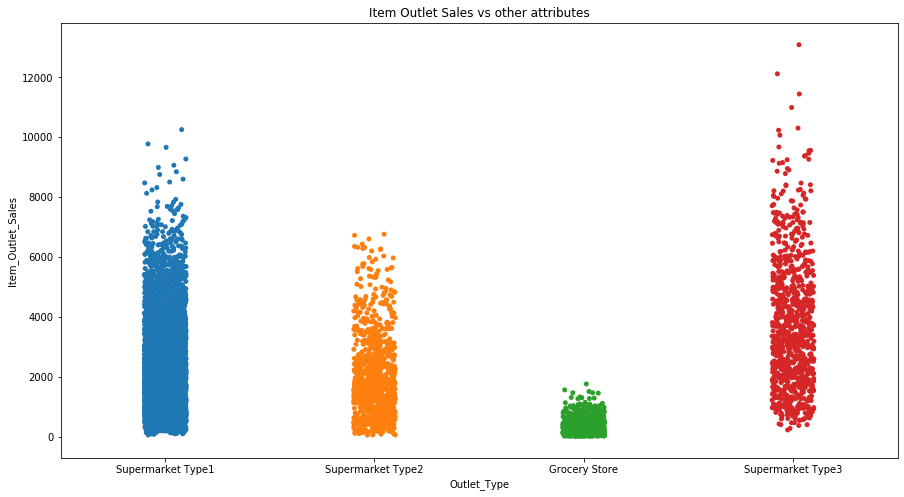

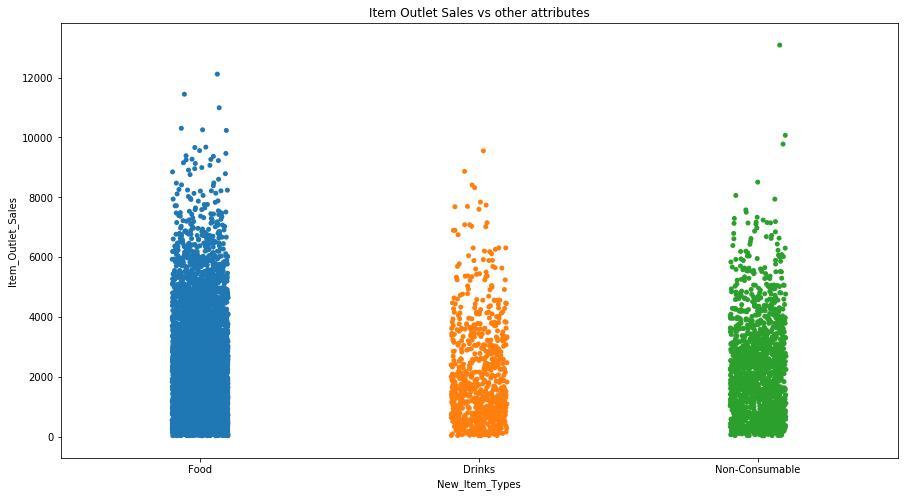

In [41]:
for i in cate_cols:                                          #bivariate analysis
    plt.figure(figsize = (15, 8))
    ax = sns.stripplot(data[i], data['Item_Outlet_Sales'])
    ax.set(xlabel = i, ylabel = 'Item_Outlet_Sales')
    plt.title('Item Outlet Sales vs other attributes')
    plt.show()

Observations from the graphs:

Tier 3 location seems to give higher item outlet sales.

Grocery stores gives the lowest items outlet sales, while supermarket type 3 gives the highest and supermarket type 1 seems to be most dense.

Food and non consumables seems to give higher item outlet sales in comparison to drinks.

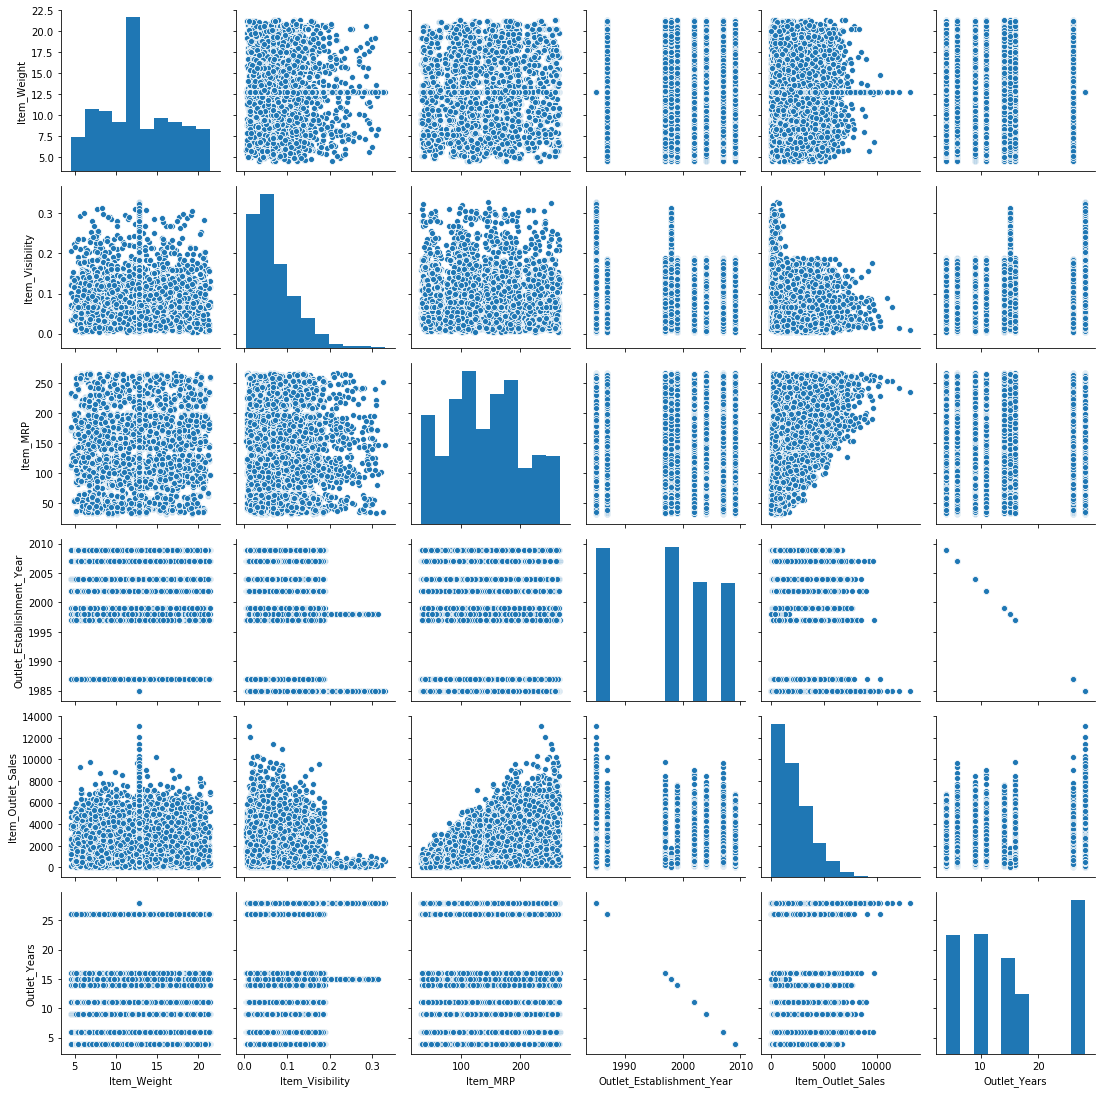

In [42]:
sns.pairplot(data)

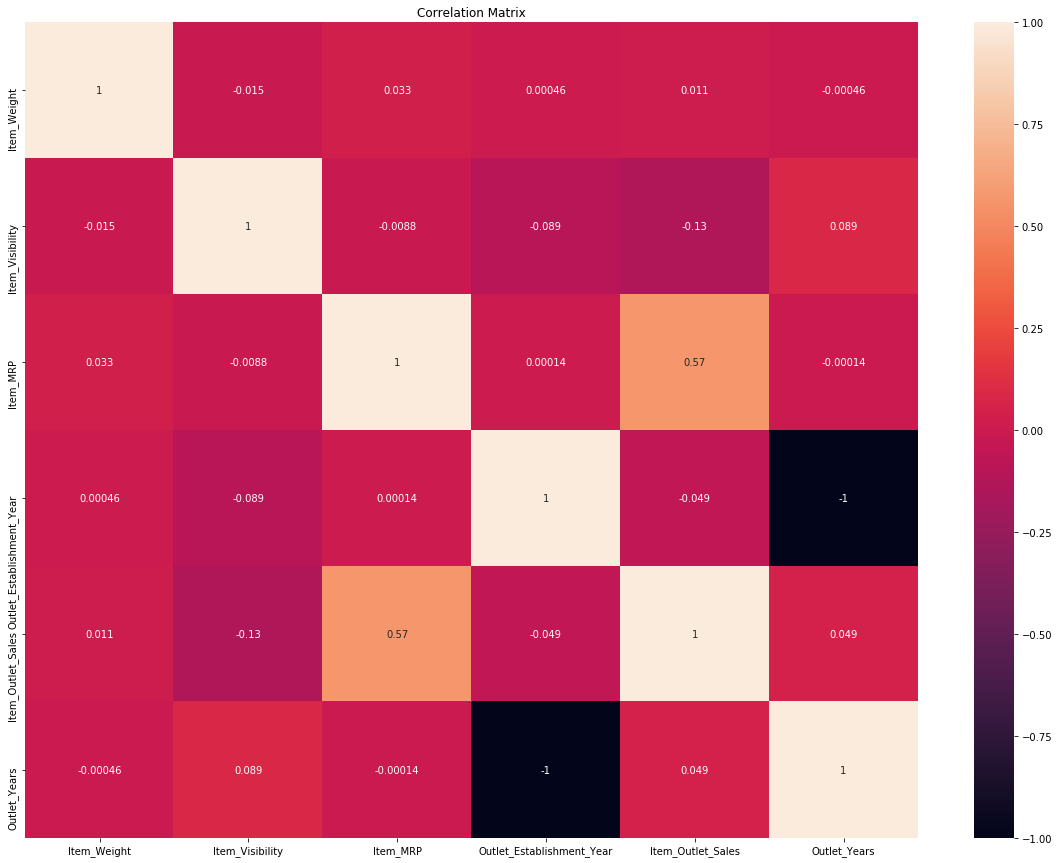

In [44]:
plt.figure(figsize = [20, 15])                             #multivariate analysis
sns.heatmap(data.corr(), annot = True)
plt.title('Correlation Matrix')
plt.show()

Observation from graph:

As we can see Item MRP has the highest correlation with item outlet sales at 0.57, apart from that all other have less than 0.15 correlation with item outlet sales with item weight being the lowest at 0.011. 

In [43]:
cate_cols.append('Item_Identifier')
cate_cols.append('Outlet_Identifier')

In [45]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
for col in cate_cols:
    data[col] = label_encoder.fit_transform(data[col])

Converting all objects type into float type data.

# Outliers and Skewness

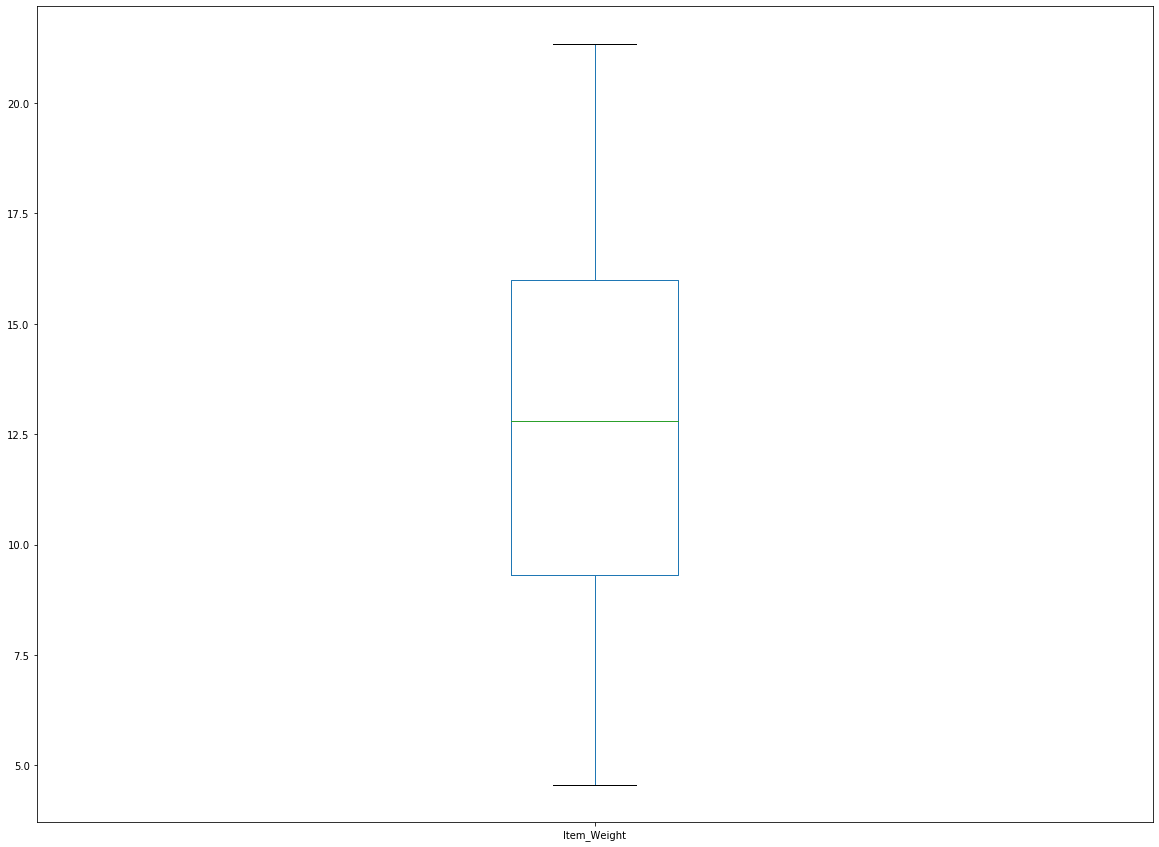

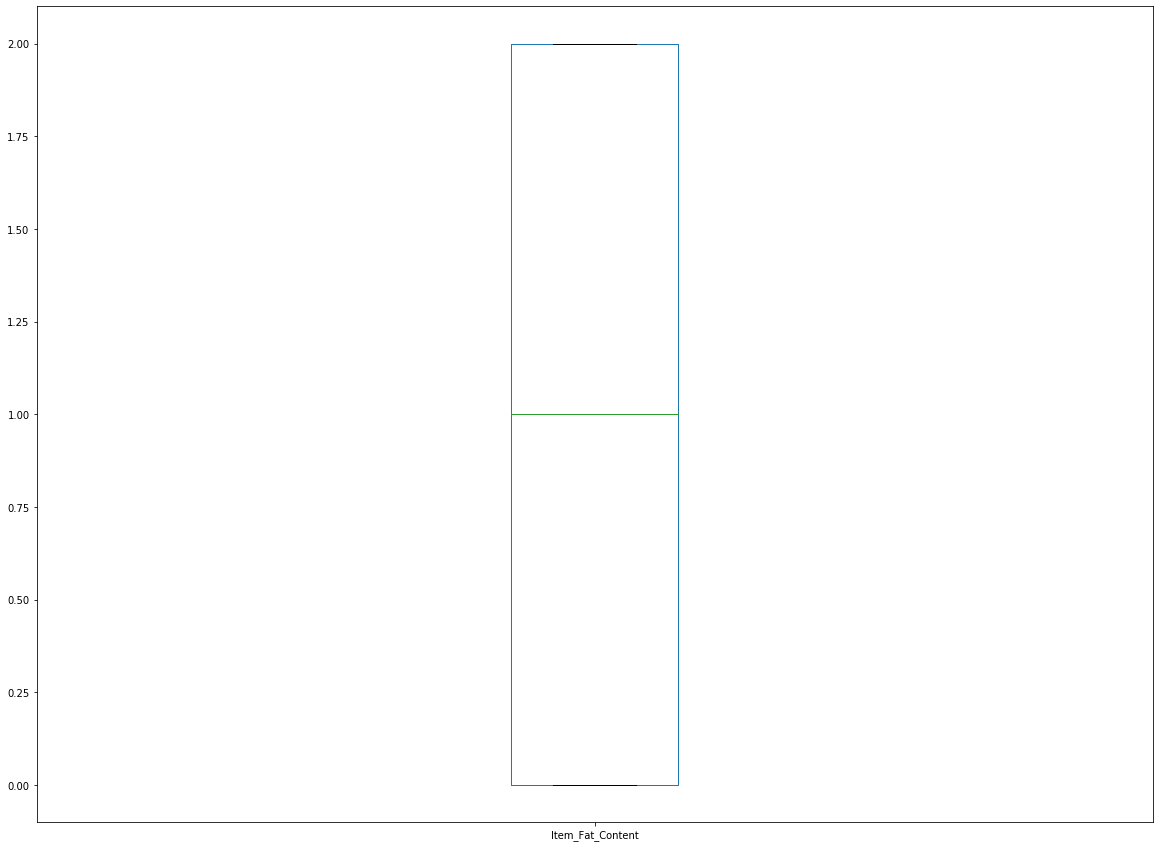

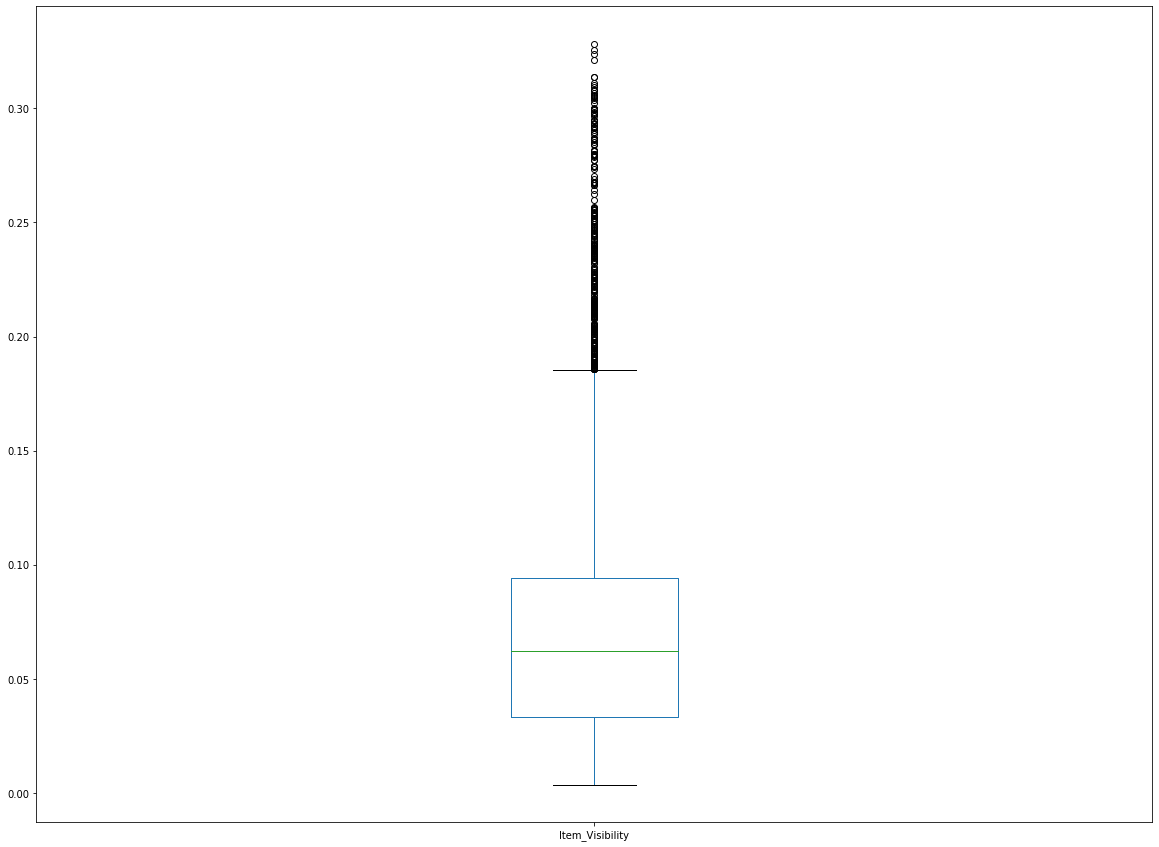

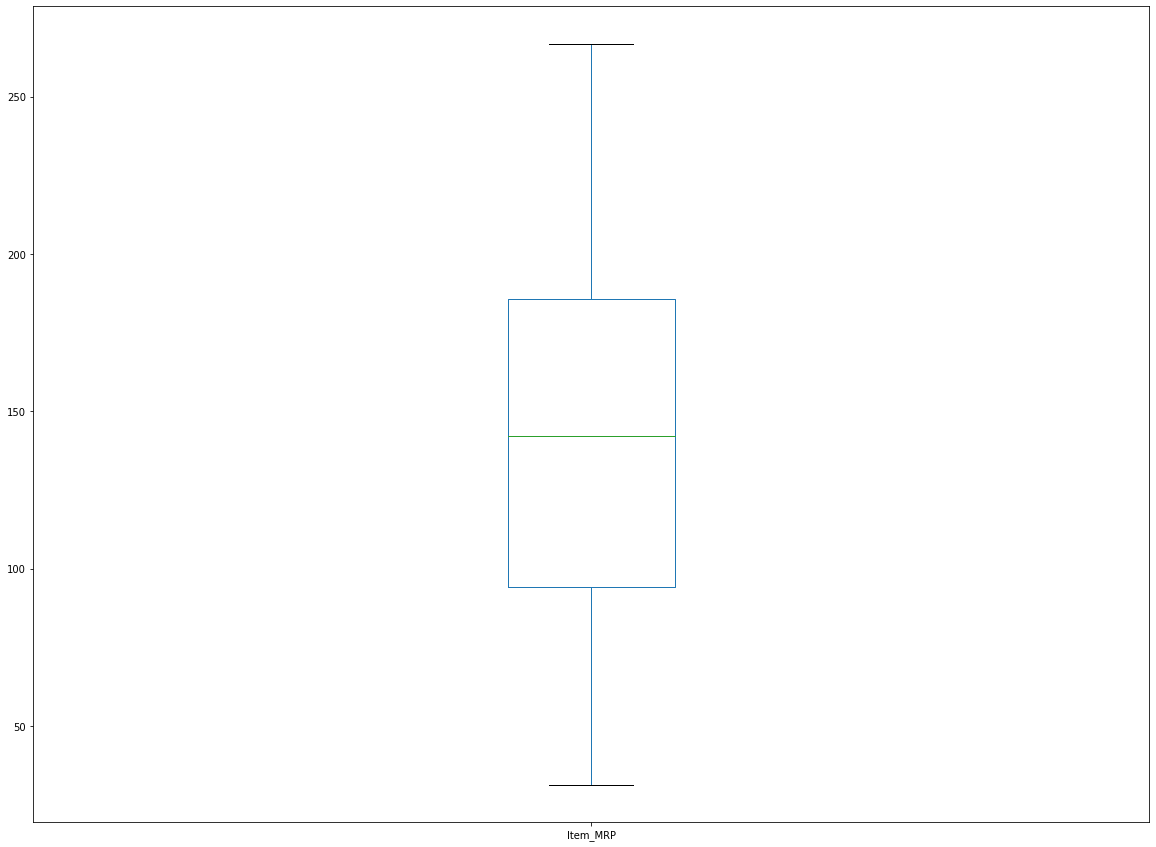

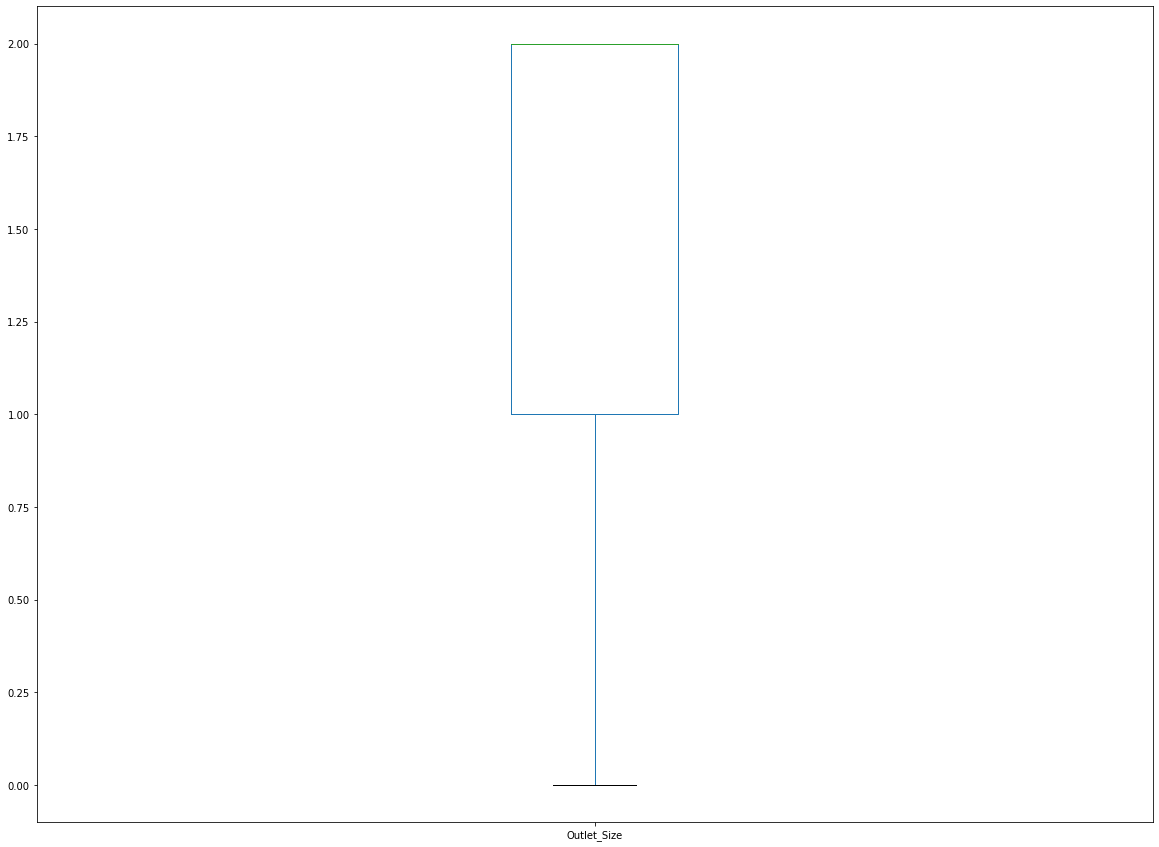

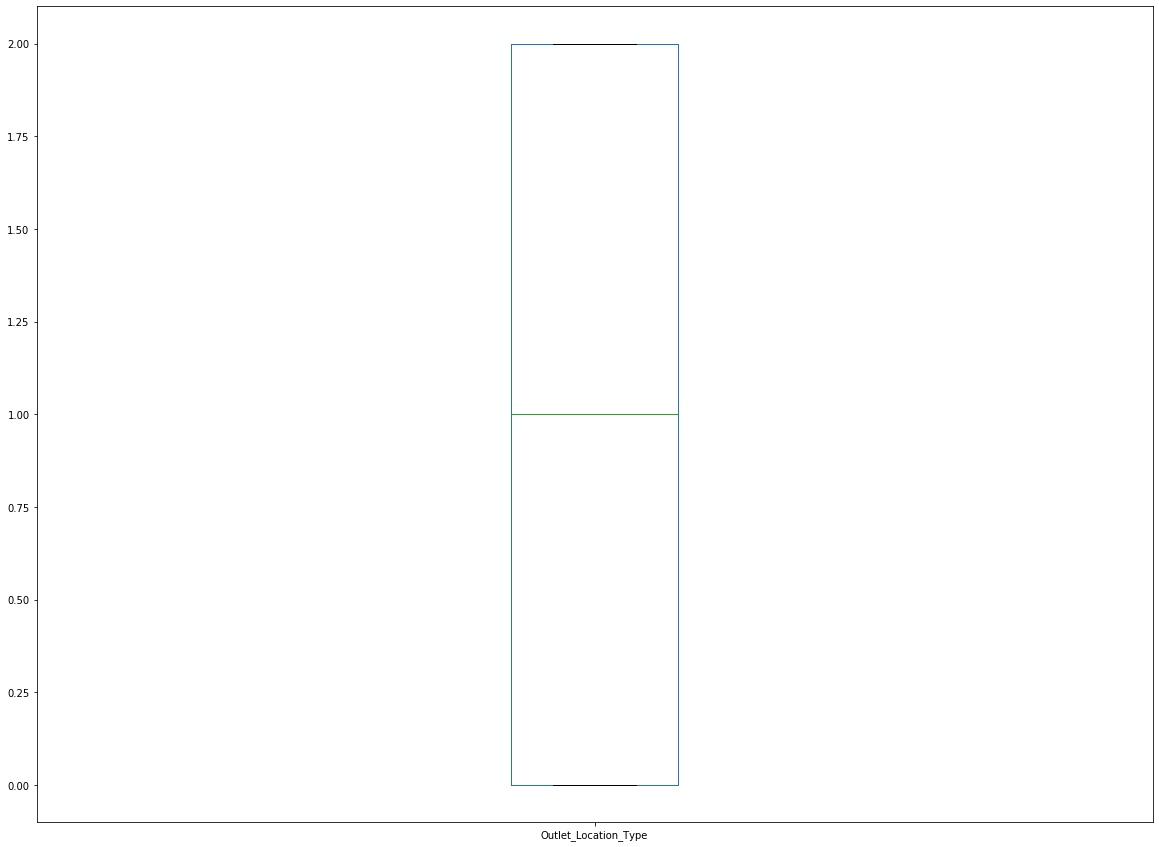

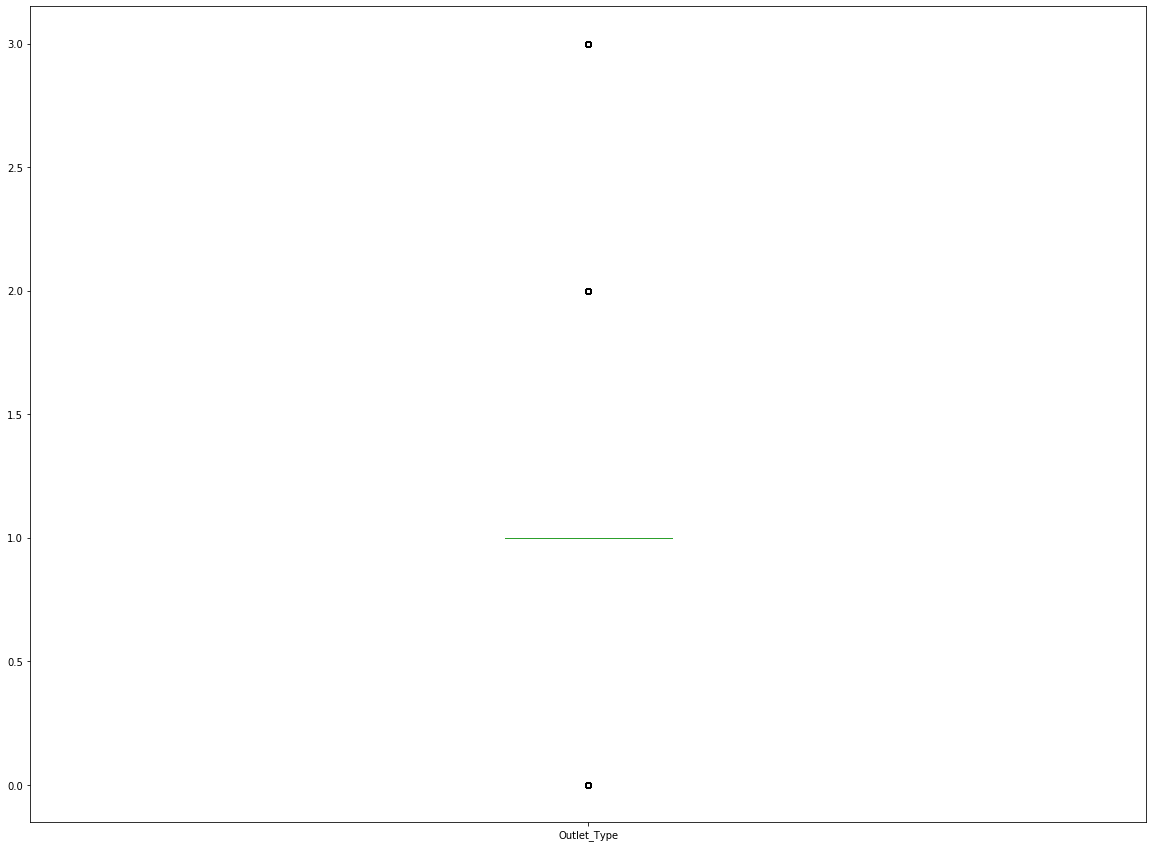

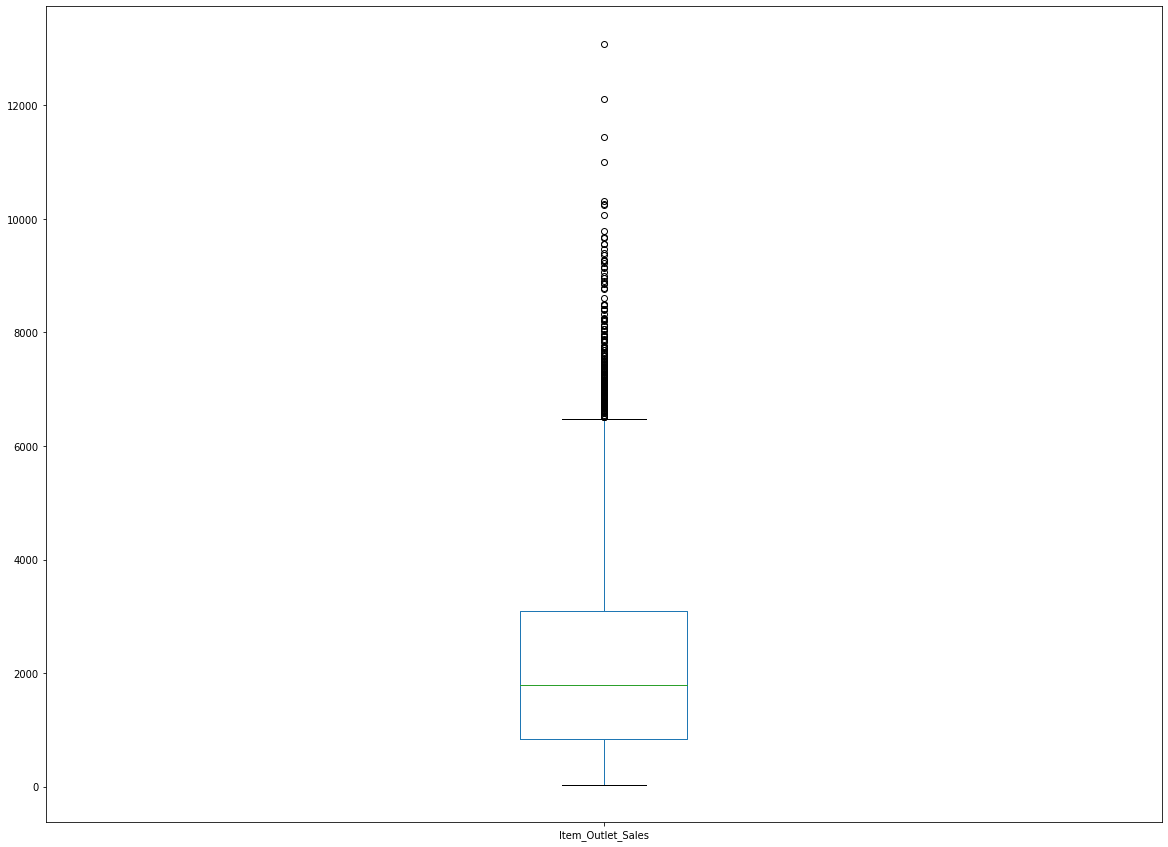

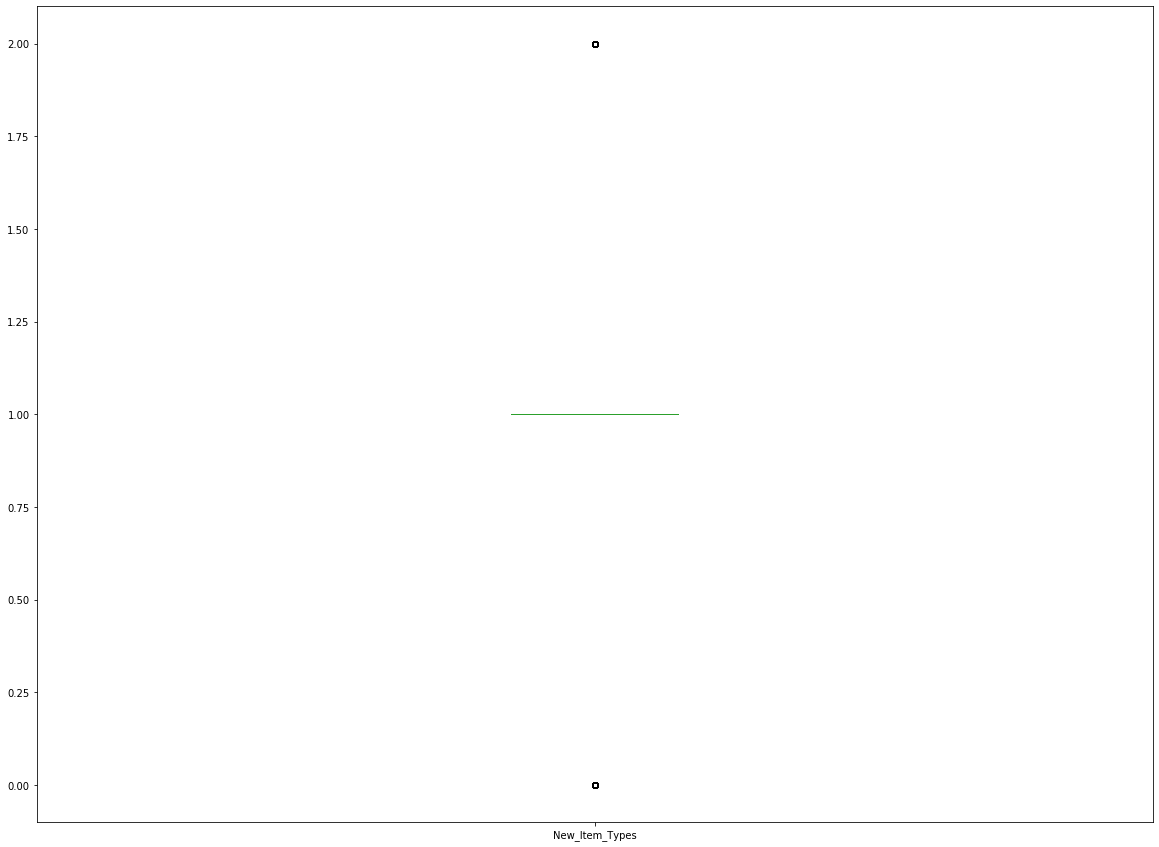

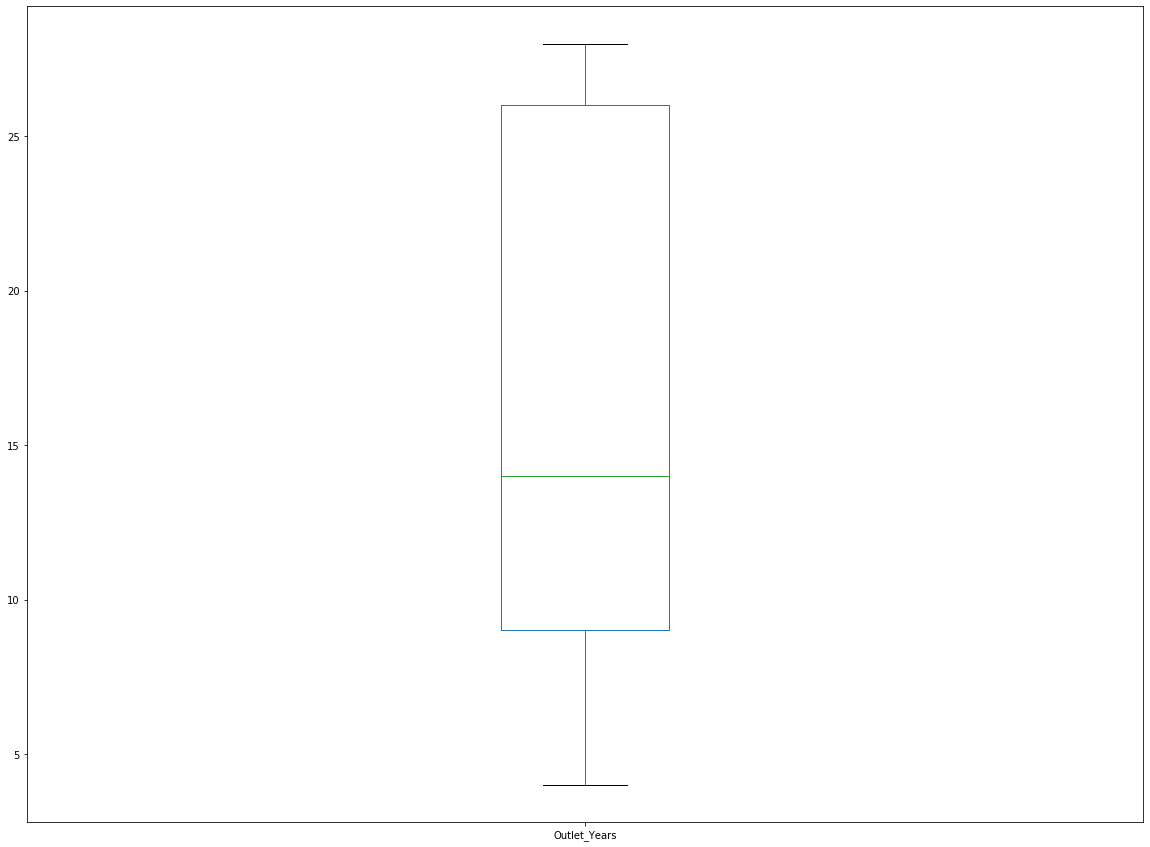

In [46]:
for i in cols:
    plt.figure(figsize = (20, 15))
    data[i].plot.box()

Only item visibility has very high number of outliers but that is also due to the treatment of missing values.

In [47]:
cols.remove('Item_Outlet_Sales')

In [48]:
data[cont_cols].skew()

Item_Weight        0.111314
Item_Visibility    1.320683
Item_MRP           0.130728
Outlet_Years       0.396465
dtype: float64

Item visibility has the high skewness, exceeding the threshold value of +-0.5.

In [49]:
data['Item_Visibility'] = np.log(data['Item_Visibility'])

In [50]:
data[cont_cols].skew()

Item_Weight        0.111314
Item_Visibility   -0.487703
Item_MRP           0.130728
Outlet_Years       0.396465
dtype: float64

The skewness in item invisibility has been brought down to acceptable amount.

In [51]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data[cols] = scaler.fit_transform(data[cols])

# Separating train and test from dataset

In [52]:
train = data.loc[data['source'] == 'train']
test = data.loc[data['source'] == 'test']

In [59]:
train.shape, test.shape

((8523, 12), (5681, 12))

In [53]:
train.drop(['source', 'Item_Type', 'Outlet_Establishment_Year'], axis = 1, inplace = True)

In [54]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,New_Item_Types,Outlet_Years
0,156,-0.824939,-1.001513,-1.599503,1.752511,9,-0.664115,-1.369286,-0.252702,3735.1380,-0.184622,-0.139681
1,8,-1.623224,1.234497,-1.358678,-1.493696,3,-0.664115,1.091566,1.002766,443.4228,-2.100160,-1.334228
2,662,1.111729,-1.001513,-1.542447,0.009874,9,-0.664115,-1.369286,-0.252702,2097.2700,-0.184622,-0.139681
3,1121,1.513233,1.234497,0.256094,0.661838,0,0.799968,1.091566,-1.508171,732.3800,-0.184622,-0.020226
4,1297,-0.912325,0.116492,0.256094,-1.403623,1,-2.128198,1.091566,-0.252702,994.7052,1.730916,1.293777


In [55]:
test.drop(['source', 'Item_Type', 'Outlet_Establishment_Year'], axis = 1, inplace = True)

In [56]:
train.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_MRP', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales', 'New_Item_Types', 'Outlet_Years'],
      dtype='object')

In [57]:
feat = ['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_MRP', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'New_Item_Types', 'Outlet_Years']

x = train[feat]
y = train['Item_Outlet_Sales']

# Best Random State

In [58]:
maxr2score = 0
maxRS = 0

for i in range (1, 500):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30, random_state = i)
    LR = LinearRegression()
    LR.fit(x_train, y_train)
    predrf = LR.predict(x_test)
    r2 = r2_score(y_test, predrf)
    if r2>maxr2score:
        maxr2score = r2
        maxRS = i
print ('Max R2 score obtained is', maxr2score, 'on Random State', maxRS)

Max R2 score obtained is 0.5285577496118716 on Random State 247


# Creating train test split

In [60]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30, random_state = 247)

In [61]:
LR = LinearRegression()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()

models = [LR, dt, rf]
for i in models:
    print (i)
    i.fit(x_train, y_train)
    pred = i.predict(x_test)
    print (r2_score(y_test, pred))
    print (mean_squared_error(y_test, pred))
    print (mean_absolute_error(y_test, pred))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
0.5285577496118716
1367730.665991262
885.9466335731922
DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')
0.12649173902115007
2534189.5737046916
1106.6754705514275
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=No

In [62]:
for i in models:
    cvs = cross_val_score(i, x, y, cv = 5)
    print ('Cross Validation Score for ',i, ' model is :', cvs.mean())
    print (' ')

Cross Validation Score for  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)  model is : 0.5005648193555163
 
Cross Validation Score for  DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')  model is : 0.14554707954374416
 
Cross Validation Score for  RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
           

Random Forest model has the R2 score of 0.56 and cross validation mean of 0.55, hence it is the best model.

# Hypertuning

In [63]:
from sklearn.model_selection import GridSearchCV

In [64]:
rf.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)>

In [65]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['mse', 'mae']
}

In [66]:
GCV = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5)
GCV.fit(x_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [67]:
GCV.best_params_

{'criterion': 'mse',
 'max_depth': 5,
 'max_features': 'auto',
 'n_estimators': 500}

In [69]:
rfr = RandomForestRegressor(random_state=42, max_features='auto', n_estimators= 500, max_depth=5, criterion='mse')
rfr.fit(x_train, y_train)
predrfr = rfr.predict(x_test)
print (r2_score(y_test, predrfr))
print (mean_squared_error(y_test, predrfr))
print (mean_absolute_error(y_test, predrfr))

0.6160888893463754
1113788.5894262425
749.0911255415749


R2 score increased from 0.56 to 0.61 after hyperparameter tuning.

In [70]:
import pickle

filename = 'BigMartRfr.pkl'
pickle.dump(rfr, open(filename, 'wb'))

# Using the Test set

In [71]:
fitted_model = pickle.load(open('BigMartRfr.pkl', 'rb'))

In [72]:
fitted_model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [84]:
t = test.dropna(axis = 1)

In [85]:
t

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,New_Item_Types,Outlet_Years
8523,1114,1.879311e+00,-1.001513,-2.586814,-0.533831,9,-0.664115,-1.369286,-0.252702,-0.184622,-0.139681
8524,1078,-1.061118e+00,1.234497,-0.453063,-0.864708,2,0.799968,-0.138860,-0.252702,-0.184622,-1.095319
8525,1420,4.268098e-01,0.116492,0.796955,1.622763,0,0.799968,1.091566,-1.508171,1.730916,-0.020226
8526,817,-1.293754e+00,-1.001513,-1.654547,0.225966,2,0.799968,-0.138860,-0.252702,-0.184622,-1.095319
8527,1197,1.082408e-13,1.234497,1.026497,1.501577,5,-0.664115,1.091566,2.258235,-0.184622,1.532686
...,...,...,...,...,...,...,...,...,...,...,...
14199,233,-5.415240e-01,1.234497,-1.826776,0.005000,8,0.799968,-1.369286,-0.252702,-0.184622,0.099229
14200,308,-1.226443e+00,1.234497,1.272042,0.453249,3,-0.664115,1.091566,1.002766,-0.184622,-1.334228
14201,1426,-6.596134e-01,0.116492,0.398848,-0.358558,7,0.799968,-0.138860,-0.252702,1.730916,-0.498045
14202,521,5.921351e-01,1.234497,0.256094,1.185747,2,0.799968,-0.138860,-0.252702,-0.184622,-1.095319


In [86]:
predictions = fitted_model.predict(t)

In [87]:
predictions

array([1616.50229194, 1479.26625542,  549.19748822, ..., 1902.83368911,
       3583.67700794, 1332.74950241])